Pulling the jena_climate_2009_2016.csv from amazon s3 and unzipping the file to the same directory where we are in. Commenting the code as it has already been done

In [29]:
# !wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
# !unzip jena_climate_2009_2016.csv.zip

Importing all the packages required

In [92]:
import os
import numpy as np
import pandas as pd
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Sequential

In [41]:
# Looking at the contents of the data and temperature is present in the 3rd column
data_dir = ''
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')
f = open(fname)
data = f.read()
f.close()
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


I am going to assign temp variabe to the temperature values which are in the 3rd column which is at python index 1 after removing the first column. Also assigning the float data here to all the rows except the first column

In [43]:

float_data = np.zeros((len(lines), len(header) - 1))
temp = np.zeros((len(lines),))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    temp[i] = values[1]
    float_data[i, :] = values

Plotting the temperature over time

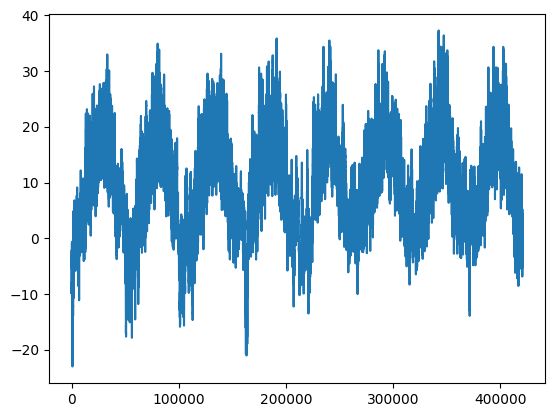

In [44]:
plt.plot(range(len(temp)), temp)

Plotting the temperature for the first 10 days to see if there is pure seasonality and it seems like there is in the later part of the 10 days,

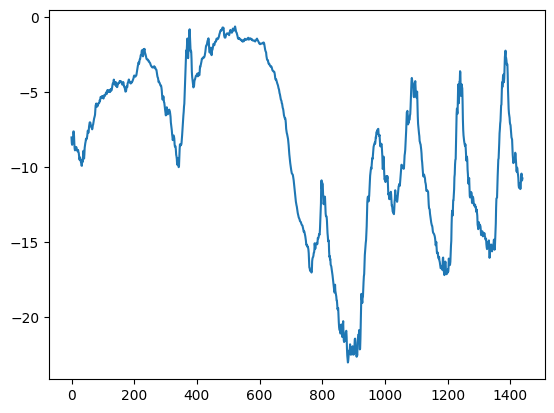

In [45]:
plt.plot(range(1440), temp[:1440])

Dividing the number of samples of entire data into training(50%), validation(25%) and testing(25%) datasets

In [46]:
# Define the proportions for train, validation, and test sets
train_proportion = 0.5
val_proportion = 0.25
test_proportion = 1 - train_proportion - val_proportion

# Calculate the number of samples for each set
train_samples = int(train_proportion * len(float_data))
val_samples = int(val_proportion * len(float_data))
test_samples = len(float_data) - train_samples - val_samples

# Print the number of samples for each set
print(train_samples)
print(val_samples)
print(test_samples)

210225
105112
105114


There will be around **210225** samples in training dataset, **105112** samples in validation dataset and **105114** samples in test dataset

We now normalize the float data which has all the contents of the dataset before we split them into the train, valid and test datasets

In [47]:
mean = float_data[:train_samples].mean(axis=0)
float_data -= mean
std = float_data[:train_samples].std(axis=0)
float_data /= std


This code is splitting up entire dataset for a RNN time series forecasting problem. 

The sampling_rate is defined as 6, indicating the rate at which data points are collected.

sequence_length is set to 120, representing the length of each sequence used for prediction.

delay is calculated based on the sampling rate and sequence length. 

The batch_size is set to 256, determining how many samples are processed together during training. 

Three datase
ts (train, validation, and test) are created using the timeseries_dataset_from_array function. 

These datasets are derived from the float_data array and corresponding targets, with appropriate sampling rates, sequence lengths, and batch sizes. 

This setup is essential for training and evaluating models on time series data.

In [48]:

sampling_rate = 6
sequence_length = 120

# In this equation, delay is being calculated based on the sampling_rate, sequence_length, and a fixed value of 24. 
# It represents the time gap between the input data and the corresponding target for each 
# sample in the dataset. This delay is crucial for aligning the input and output correctly
# during training, ensuring that the model learns to make accurate predictions based on 
#historical data. The -1 term in the equation is used to account for the fact that indexing starts from zero.
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    float_data[:-delay],
    targets=temp[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    float_data[:-delay],
    targets=temp[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=train_samples,
    end_index=train_samples + val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    float_data[:-delay],
    targets=temp[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=train_samples + val_samples)


It seems like 120 previous time periods are being used to predict the next 10 mins' forecast

In [66]:
for batch in train_dataset:
    inputs, targets = batch
    print(len(inputs[0]))
    print(targets[0])
    break

120
tf.Tensor(-4.25, shape=(), dtype=float64)


# using the most naive model as a baseline to compare the later neural network models efficiency
# Naive model here is to predict the next value using the last value in the input sequence
# Model 1

In [74]:
def calculate_mean_absolute_error(dataset):
    total_absolute_error = 0
    total_samples = 0

    for samples, targets in dataset:
        predictions = samples[:, -1, 1] * std[1] + mean[1]
        total_absolute_error += np.sum(np.abs(predictions - targets))
        total_samples += samples.shape[0]

    return total_absolute_error / total_samples

validation_mae = calculate_mean_absolute_error(val_dataset)

print(f" {validation_mae:.2f}")

 2.44


# Validation Mean absolute error is around 2.44 for the naive model, we would like to see how the neural network models try to beat this

## First neural network that we are building is the simple fully connected model that starts by flattening the data and then runs it through two Dense layers.

# Model 2

In [79]:
inputs = keras.Input(shape=(sequence_length, float_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [80]:
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense_model2.keras",
                                    save_best_only=True)]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=10,
                    validation_data = val_dataset, callbacks=callbacks)


Epoch 1/10
819/819 [==============================] - 28s 33ms/step - loss: 12.8043 - mae: 2.7616 - val_loss: 11.9171 - val_mae: 2.7362
Epoch 2/10
819/819 [==============================] - 26s 31ms/step - loss: 8.8702 - mae: 2.3459 - val_loss: 13.3989 - val_mae: 2.9239
Epoch 3/10
819/819 [==============================] - 25s 31ms/step - loss: 8.2310 - mae: 2.2637 - val_loss: 10.8393 - val_mae: 2.6128
Epoch 4/10
819/819 [==============================] - 27s 33ms/step - loss: 7.8305 - mae: 2.2075 - val_loss: 11.9049 - val_mae: 2.7288
Epoch 5/10
819/819 [==============================] - 24s 30ms/step - loss: 7.5732 - mae: 2.1721 - val_loss: 12.7470 - val_mae: 2.8399
Epoch 6/10
819/819 [==============================] - 25s 30ms/step - loss: 7.3874 - mae: 2.1453 - val_loss: 11.3075 - val_mae: 2.6713
Epoch 7/10
819/819 [==============================] - 25s 30ms/step - loss: 7.1938 - mae: 2.1180 - val_loss: 11.3838 - val_mae: 2.6721
Epoch 8/10
819/819 [==============================] - 

Plotting the training and validation MAE over time

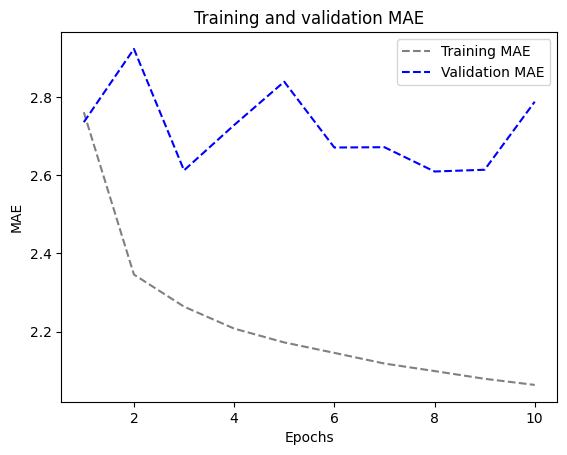

In [81]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

In [82]:
model = keras.models.load_model("jena_dense_model2.keras")
print(f"Validation MAE: {model.evaluate(val_dataset)[1]:.2f}")

408/408 [==============================] - 8s 20ms/step - loss: 10.8119 - mae: 2.6099
Validation MAE: 2.61


Model 2 which is a simple dense connected layer neural network which has a validation MAE of 2.61 which is worse than the naive model. It seems like our common sense is doing a better job than the simple neural network here. This seems to be overfitting for sure as the training and validaiton losses deviate after 1st epoch.


Probably time to try a Recurrent neural network now.

# Model 3: training a GRU model

In [86]:
inputs = keras.Input(shape=(sequence_length, float_data.shape[-1]))
x = layers.GRU(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_gru_model3.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_gru_model3.keras")
print(f"Validation MAE: {model.evaluate(val_dataset)[1]:.2f}")


Epoch 1/10
819/819 [==============================] - 28s 32ms/step - loss: 44.3582 - mae: 4.8580 - val_loss: 13.8456 - val_mae: 2.7894
Epoch 2/10
819/819 [==============================] - 26s 31ms/step - loss: 10.8912 - mae: 2.5633 - val_loss: 9.5913 - val_mae: 2.3985
Epoch 3/10
819/819 [==============================] - 25s 31ms/step - loss: 9.7165 - mae: 2.4350 - val_loss: 9.4741 - val_mae: 2.3808
Epoch 4/10
819/819 [==============================] - 26s 31ms/step - loss: 9.2640 - mae: 2.3765 - val_loss: 9.4057 - val_mae: 2.3655
Epoch 5/10
819/819 [==============================] - 26s 31ms/step - loss: 9.0052 - mae: 2.3429 - val_loss: 9.0891 - val_mae: 2.3353
Epoch 6/10
819/819 [==============================] - 25s 31ms/step - loss: 8.7963 - mae: 2.3161 - val_loss: 9.0645 - val_mae: 2.3272
Epoch 7/10
819/819 [==============================] - 25s 31ms/step - loss: 8.5922 - mae: 2.2918 - val_loss: 9.1569 - val_mae: 2.3414
Epoch 8/10
819/819 [==============================] - 25s 3

# Validation MAE for the Model 3 is around 2.33 which is definitely an improvement over the Naive model which has MAE of 2.44


Plotting the validation and train MAE over the number of epochs to see if the overfitting still exists

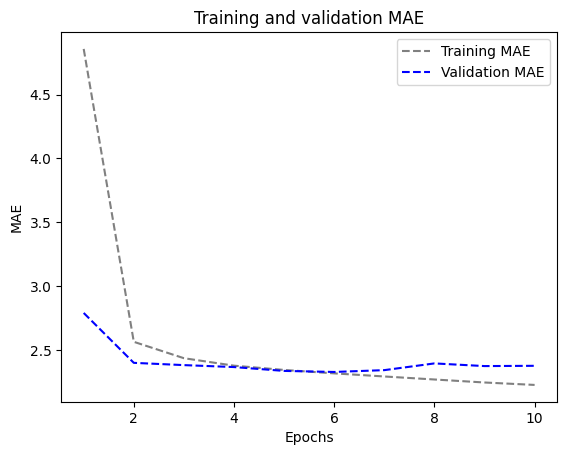

In [87]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

This is so much better than the previous simple neural network and it seems like the validation loss has deviated a bit in the last few number of epochs(but is consistent)

Let's see if adding recurrent dropout and dropout regularization to this improves the model a bit more or at least prevents overfitting to the fullest

# Model 4: Adding recurrent dropout and dropout

In [89]:

inputs = keras.Input(shape=(sequence_length, float_data.shape[-1]))
x = layers.GRU(16, dropout=0.2, recurrent_dropout=0.2)(inputs)  # Added dropout and recurrent_dropout
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_gru_model4_with_dropout.keras", save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

model = keras.models.load_model("jena_gru_model4_with_dropout.keras")
print(f"Validation MAE: {model.evaluate(val_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 264s 319ms/step - loss: 43.8816 - mae: 4.8399 - val_loss: 13.4745 - val_mae: 2.7815
Epoch 2/10
819/819 [==============================] - 262s 320ms/step - loss: 11.7256 - mae: 2.6719 - val_loss: 10.2390 - val_mae: 2.4641
Epoch 3/10
819/819 [==============================] - 263s 320ms/step - loss: 10.6824 - mae: 2.5622 - val_loss: 10.2594 - val_mae: 2.4474
Epoch 4/10
819/819 [==============================] - 263s 321ms/step - loss: 10.1683 - mae: 2.5012 - val_loss: 9.5347 - val_mae: 2.3703
Epoch 5/10
819/819 [==============================] - 264s 323ms/step - loss: 9.8535 - mae: 2.4651 - val_loss: 9.9432 - val_mae: 2.3968
Epoch 6/10
819/819 [==============================] - 263s 321ms/step - loss: 9.6425 - mae: 2.4385 - val_loss: 9.7845 - val_mae: 2.3820
Epoch 7/10
819/819 [==============================] - 264s 322ms/step - loss: 9.4714 - mae: 2.4174 - val_loss: 9.6055 - val_mae: 2.3650
Epoch 8/10
819/819 [=====================

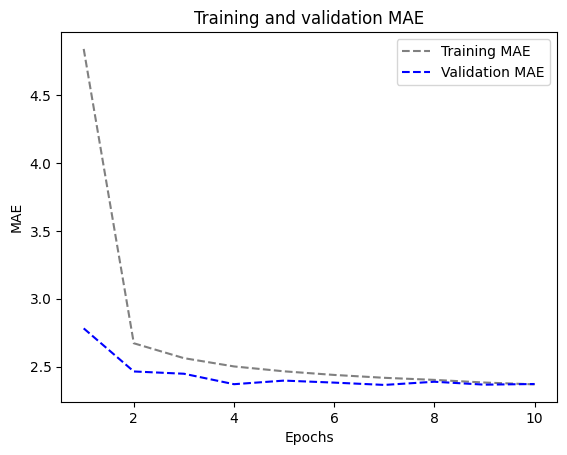

In [90]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

Model 4's validation MAE 2.37 is higher than previous model(2.33). It seems like this model with recurrent dropout and dropout did not improve the model but is definitely consistent over the number of epochs and did not deviate higher than the training MAE in the late epochs.

# Model 5 - Stacked recurrent layers(GRU 16 units, GRU 32 units) without dropout/recurrent dropout

In [102]:
# Define the model
inputs = keras.Input(shape=(sequence_length, float_data.shape[-1]))
x = layers.GRU(16, return_sequences=True)(inputs)
x = layers.GRU(32)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("stacked_gru_model5_w_16_32.keras", save_best_only=True)
]

# Train the model
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

# Evaluate the model
model = keras.models.load_model("stacked_gru_model5_w_16_32.keras")
validation_mae = model.evaluate(val_dataset)[1]

print(f"Validation MAE: {validation_mae:.2f}")


Epoch 1/10
819/819 [==============================] - 32s 35ms/step - loss: 23.2105 - mae: 3.4378 - val_loss: 9.8529 - val_mae: 2.4451
Epoch 2/10
819/819 [==============================] - 28s 34ms/step - loss: 9.4772 - mae: 2.3991 - val_loss: 8.8284 - val_mae: 2.3050
Epoch 3/10
819/819 [==============================] - 28s 34ms/step - loss: 8.8343 - mae: 2.3182 - val_loss: 9.4993 - val_mae: 2.3819
Epoch 4/10
819/819 [==============================] - 28s 34ms/step - loss: 8.3512 - mae: 2.2573 - val_loss: 9.4159 - val_mae: 2.3776
Epoch 5/10
819/819 [==============================] - 28s 34ms/step - loss: 7.8648 - mae: 2.1921 - val_loss: 10.7091 - val_mae: 2.5327
Epoch 6/10
819/819 [==============================] - 28s 34ms/step - loss: 7.3480 - mae: 2.1199 - val_loss: 9.8345 - val_mae: 2.4451
Epoch 7/10
819/819 [==============================] - 28s 34ms/step - loss: 6.9013 - mae: 2.0566 - val_loss: 10.1922 - val_mae: 2.4903
Epoch 8/10
819/819 [==============================] - 28s 3

Model 5: Stacked GRU layers with 16, 32 units without dropout seems to be performing better than the previous models with validation MAE of 2.30. This is the best model so far.

Let us check how the training/validation mae evolved over the number of epochs:

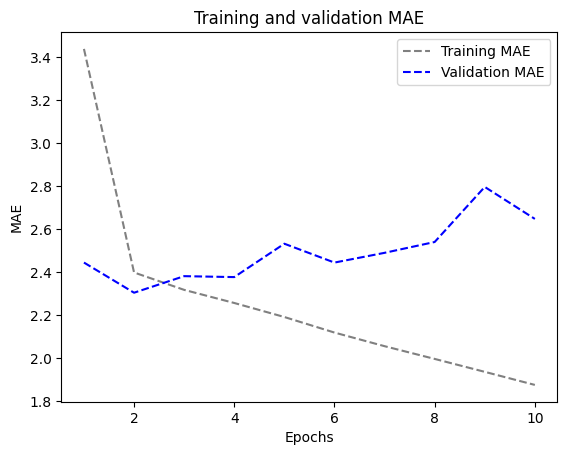

In [103]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

It seems like the model is definitely overfitting as the validation MAE is growing higher over the number of epochs. We will now try Model 6 where we increase the units in first GRU layer of stacked GRU layers and see how the model performance change. Once we figure out which stacked layers configuration is performing best, we can probably apply dropout on the best model and see how that changes.

# Model 6: 2 Stacked GRU layers, with 32 and 32 units respectively without dropout/recurrent dropout

In [104]:
# Define the model
inputs = keras.Input(shape=(sequence_length, float_data.shape[-1]))
x = layers.GRU(32, return_sequences=True)(inputs)
x = layers.GRU(32)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("stacked_gru_model6_w_32_32.keras", save_best_only=True)
]

# Train the model
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

# Evaluate the model
model = keras.models.load_model("stacked_gru_model6_w_32_32.keras")
validation_mae = model.evaluate(val_dataset)[1]

print(f"Validation MAE: {validation_mae:.2f}")


Epoch 1/10
819/819 [==============================] - 33s 35ms/step - loss: 18.8523 - mae: 3.1321 - val_loss: 9.3752 - val_mae: 2.3785
Epoch 2/10
819/819 [==============================] - 28s 34ms/step - loss: 8.7472 - mae: 2.3074 - val_loss: 9.1007 - val_mae: 2.3474
Epoch 3/10
819/819 [==============================] - 28s 34ms/step - loss: 7.6673 - mae: 2.1717 - val_loss: 9.8099 - val_mae: 2.4424
Epoch 4/10
819/819 [==============================] - 28s 34ms/step - loss: 6.7933 - mae: 2.0451 - val_loss: 10.7405 - val_mae: 2.5514
Epoch 5/10
819/819 [==============================] - 29s 35ms/step - loss: 6.0190 - mae: 1.9224 - val_loss: 11.8297 - val_mae: 2.6767
Epoch 6/10
819/819 [==============================] - 29s 35ms/step - loss: 5.2651 - mae: 1.7965 - val_loss: 12.7469 - val_mae: 2.7712
Epoch 7/10
819/819 [==============================] - 28s 34ms/step - loss: 4.5905 - mae: 1.6765 - val_loss: 14.2301 - val_mae: 2.9280
Epoch 8/10
819/819 [==============================] - 28s

Model 6: Stacked GRU layers with 32, 32 units without dropout seems to be performing worse than the previous model with validation MAE of 2.35. 

It seems like as we increased the units in the first GRU layer and keeping the same units in the second layers worsened the performance

Let us check how the training/validation mae evolved over the number of epochs:

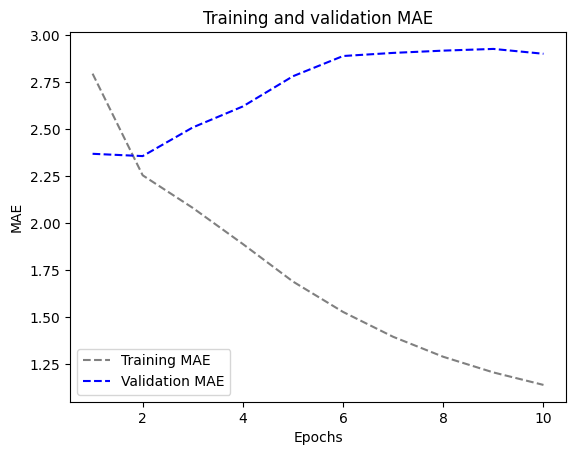

In [111]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

It seems like the model is definitely overfitting as the validation MAE is growing higher over the number of epochs. We will now try Model 7 where we increase the units in second GRU layer of stacked GRU layers while keeping the first layer units the same and see how the model performance changes.

# Model 7: 2 Stacked GRU layers, with 32 and 64 units respectively without dropout/recurrent dropout

In [112]:
# Define the model
inputs = keras.Input(shape=(sequence_length, float_data.shape[-1]))
x = layers.GRU(32, return_sequences=True)(inputs)
x = layers.GRU(64)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("stacked_gru_model7_w_32_64.keras", save_best_only=True)
]

# Train the model
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

# Evaluate the model
model = keras.models.load_model("stacked_gru_model7_w_32_64.keras")
validation_mae = model.evaluate(val_dataset)[1]

print(f"Validation MAE: {validation_mae:.2f}")


Epoch 1/10
819/819 [==============================] - 32s 35ms/step - loss: 14.1928 - mae: 2.8032 - val_loss: 9.0613 - val_mae: 2.3322
Epoch 2/10
819/819 [==============================] - 28s 34ms/step - loss: 8.6867 - mae: 2.3058 - val_loss: 9.5991 - val_mae: 2.3979
Epoch 3/10
819/819 [==============================] - 28s 33ms/step - loss: 7.4507 - mae: 2.1453 - val_loss: 10.3153 - val_mae: 2.4963
Epoch 4/10
819/819 [==============================] - 28s 34ms/step - loss: 6.2480 - mae: 1.9680 - val_loss: 10.1430 - val_mae: 2.4811
Epoch 5/10
819/819 [==============================] - 28s 34ms/step - loss: 5.0854 - mae: 1.7727 - val_loss: 11.3137 - val_mae: 2.5994
Epoch 6/10
819/819 [==============================] - 28s 34ms/step - loss: 4.1143 - mae: 1.5907 - val_loss: 12.0200 - val_mae: 2.6767
Epoch 7/10
819/819 [==============================] - 28s 34ms/step - loss: 3.3551 - mae: 1.4344 - val_loss: 12.8250 - val_mae: 2.7743
Epoch 8/10
819/819 [==============================] - 28

Model 7: Stacked GRU layers with 32, 64 units without dropout seems to be performing better than the Model 6 with validation MAE of 2.33, but worse than the Model 5 which is the best performer so far.

It seems like as we increased the units in the second GRU layer and keeping the same units in the first layer improved the performance

Let us check how the training/validation mae evolved over the number of epochs:

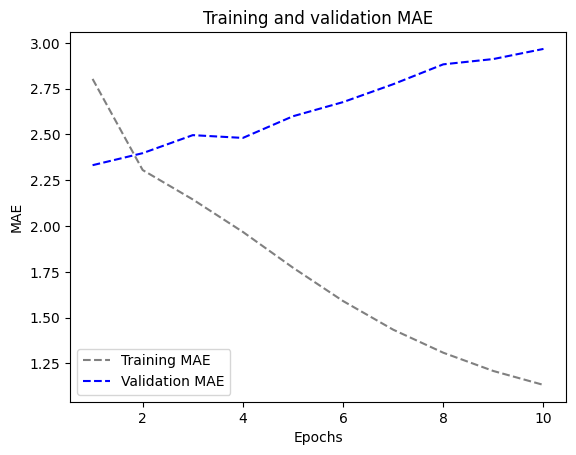

In [113]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

It seems like this model is definitely overfitting again as the validation MAE deviates after 2nd epoch.

Let's use the best stacking model configuration above which is: stacked GRU layers with 16 and 32 units and apply recurrent dropout and dropout to see if the validation MAE does not deviate from the training MAE

# Model 8: 2 Stacked GRU layers, with 16 and 32 units respectively with dropout/recurrent dropout

In [ ]:
# Define the model
inputs = keras.Input(shape=(sequence_length, float_data.shape[-1]))
x = layers.GRU(16, dropout = 0.1, recurrent_dropout = 0.5, return_sequences=True)(inputs)
x = layers.GRU(32, activation='relu', dropout=0.1, recurrent_dropout=0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("stacked_gru_model8_w_16_32_w_dropout.keras", save_best_only=True)
]

# Train the model
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

# Evaluate the model
model = keras.models.load_model("stacked_gru_model8_w_16_32_w_dropout.keras")
validation_mae = model.evaluate(val_dataset)[1]

print(f"Validation MAE: {validation_mae:.2f}")


Epoch 1/10
819/819 [==============================] - 597s 723ms/step - loss: 19.3386 - mae: 3.2508 - val_loss: 12.4595 - val_mae: 2.7762
Epoch 2/10
819/819 [==============================] - 591s 721ms/step - loss: 10.6081 - mae: 2.5527 - val_loss: 9.8178 - val_mae: 2.4262
Epoch 3/10
386/819 [=============>................] - ETA: 5:00 - loss: 10.0964 - mae: 2.4899

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

In [ ]:
# Model 9 : Using simple LSTM model

In [ ]:
inputs = keras.Input(shape=(sequence_length, float_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_model9.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm_model9.keras")
print(f"Validation MAE: {model.evaluate(val_dataset)[1]:.2f}")


In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

In [ ]:
inputs = keras.Input(shape=(sequence_length, float_data.shape[-1]))
x = layers.LSTM(16, dropout=0.2, recurrent_dropout=0.2)(inputs)  # Added dropout and recurrent_dropout
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_model10_with_dropout.keras", save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

model = keras.models.load_model("jena_lstm_model10_with_dropout.keras")
print(f"Validation MAE: {model.evaluate(val_dataset)[1]:.2f}")

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

In [ ]:
# Define the model
inputs = keras.Input(shape=(sequence_length, float_data.shape[-1]))
x = layers.LSTM(16, return_sequences=True)(inputs)
x = layers.LSTM(32)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("stacked_lstm_model11_w_16_32.keras", save_best_only=True)
]

# Train the model
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

# Evaluate the model
model = keras.models.load_model("stacked_lstm_model11_w_16_32.keras")
validation_mae = model.evaluate(val_dataset)[1]

print(f"Validation MAE: {validation_mae:.2f}")

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

In [ ]:
# Define the model
inputs = keras.Input(shape=(sequence_length, float_data.shape[-1]))
x = layers.LSTM(32, return_sequences=True)(inputs)
x = layers.LSTM(32)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("stacked_lstm_model12_w_32_32.keras", save_best_only=True)
]

# Train the model
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

# Evaluate the model
model = keras.models.load_model("stacked_lstm_model12_w_32_32.keras")
validation_mae = model.evaluate(val_dataset)[1]

print(f"Validation MAE: {validation_mae:.2f}")

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

In [ ]:
# Define the model
inputs = keras.Input(shape=(sequence_length, float_data.shape[-1]))
x = layers.LSTM(32, return_sequences=True)(inputs)
x = layers.LSTM(64)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("stacked_lstm_model13_w_32_64.keras", save_best_only=True)
]

# Train the model
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

# Evaluate the model
model = keras.models.load_model("stacked_lstm_model13_w_32_64.keras")
validation_mae = model.evaluate(val_dataset)[1]

print(f"Validation MAE: {validation_mae:.2f}")

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

In [ ]:
# Define the model
inputs = keras.Input(shape=(sequence_length, float_data.shape[-1]))
x = layers.GRU(16, dropout = 0.1, recurrent_dropout = 0.5, return_sequences=True)(inputs)
x = layers.GRU(32, activation='relu', dropout=0.1, recurrent_dropout=0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("stacked_gru_model14_w_16_32_w_dropout.keras", save_best_only=True)
]

# Train the model
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

# Evaluate the model
model = keras.models.load_model("stacked_gru_model14_w_16_32_w_dropout.keras")
validation_mae = model.evaluate(val_dataset)[1]

print(f"Validation MAE: {validation_mae:.2f}")


In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(32, 3, activation='relu')(inputs)
x = layers.MaxPooling1D(3)(x)
x = layers.Conv1D(64, 3, activation='relu')(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Reshape((-1, 64))(x)  # Reshape the data to be 3D
x = layers.LSTM(16)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_1d_Conv_LSTM_model15.keras", save_best_only=True)
]

history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

model = keras.models.load_model("jena_Conv_LSTM_model15.keras")
print(f"Validation MAE: {model.evaluate(val_dataset)[1]:.2f}")

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()